In [2]:
import numpy as np
from scipy import signal
import scipy.stats
import matplotlib.pyplot as plt  # For plotting
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
figlist = []
#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                           
params = {'figure.figsize': (16, 12),
          'xtick.labelsize':'xx-large',
          'ytick.labelsize':'xx-large',
          'text.usetex': False,
          'lines.linewidth': 4,
          'font.family': 'serif',
          'font.serif': 'Georgia',
          'font.size': 20,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium',
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'axes.grid.axis': 'both',
          'axes.grid.which': 'both',
          'axes.grid': True,
          'grid.color': 'xkcd:cement',
          'grid.alpha': 0.3,
          'lines.markersize': 12,
          'lines.linewidth': 2.0,
          'legend.borderpad': 0.2,
          'legend.fancybox': True,
          'legend.fontsize': 'medium',
          'legend.framealpha': 0.8,
          'legend.handletextpad': 0.5,
          'legend.labelspacing': 0.33,
          'legend.loc': 'best',
          'savefig.dpi': 140,
          'savefig.bbox': 'tight',
          'pdf.compression': 9}
pylab.rcParams.update(params)
#********************************************************************************************************

In [3]:
tsData = np.loadtxt('/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200528_SuperBNMeasurementSR/Data/BeatnoteTimeSeries_20200529_033233.txt')

In [4]:
timeSeries = tsData[:, 0]
noiseSig = tsData[:, 1]
noiseSig = signal.detrend(noiseSig, type='linear')
SampleRate = 1/(timeSeries[1] - timeSeries[0])
print(SampleRate)

15625.0


In [5]:
noverlap = 0
timeSeg = 1  # s
nperseg = int(timeSeg * SampleRate)
#Sort data into rows with number in each row = to nperseg
# length of columns
col_len=0
end_edge=nperseg
while(end_edge<len(noiseSig)):
    end_edge=end_edge+nperseg-noverlap
    col_len=col_len+1

# make array of row length nperseg and column length however much data
# will fit fully in row
sorted_data = np.zeros((col_len,nperseg))

# make array for PSD will have same col len but
# row len = max freq/freq_spacing + 1
# or (samplerate/2) /(samplerate/nperseg) + 1 which = nperseg/2 +1
welch_array = np.zeros((col_len, nperseg//2 + 1))

#Move through signal data array populating array
next_start=0
for ii in range(col_len):
    sorted_data[ii, :] = noiseSig[next_start: next_start+nperseg]
    next_start = next_start+nperseg-noverlap

In [6]:
# Do row-wise welch
for k in range(col_len):
    ff, welch_array[k, :] = signal.welch(sorted_data[k, :], SampleRate,
                                         window = 'hann',
                                         nperseg = nperseg)

In [7]:
# Rebin to remove correlations
rebinSize = 5
skip=3
redff = np.zeros(len(ff[skip:])//rebinSize)
redWelchArr = np.zeros((col_len, len(redff)))
for ii in range(len(redff)):
    startInd = skip + rebinSize * ii
    endInd = skip + rebinSize * (ii + 1)
    redff[ii] = np.mean(ff[startInd:endInd])
    for k in range(col_len):
        redWelchArr[k, ii] = np.mean(welch_array[k, startInd:endInd])

In [8]:
# Reduce PSD to frequencies of interest
lowerCutoffFreq = 50
upperCutoffFreq = 600
redWelchArr = redWelchArr[:, redff>lowerCutoffFreq]
redff = redff[redff>lowerCutoffFreq]
redWelchArr = redWelchArr[:, redff<upperCutoffFreq]
redff = redff[redff<upperCutoffFreq]

In [9]:
redff

array([ 55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355., 360., 365., 370., 375., 380.,
       385., 390., 395., 400., 405., 410., 415., 420., 425., 430., 435.,
       440., 445., 450., 455., 460., 465., 470., 475., 480., 485., 490.,
       495., 500., 505., 510., 515., 520., 525., 530., 535., 540., 545.,
       550., 555., 560., 565., 570., 575., 580., 585., 590., 595.])

In [10]:
redWelchArr

array([[0.05039612, 0.02046707, 0.00778629, ..., 0.00051675, 0.00075707,
        0.00014433],
       [0.00241876, 0.01387965, 0.01740912, ..., 0.00075167, 0.0020308 ,
        0.00131146],
       [0.00486234, 0.00990608, 0.00228926, ..., 0.00112181, 0.00048273,
        0.00037943],
       ...,
       [0.03953461, 0.02805919, 0.00590184, ..., 0.00158789, 0.00023042,
        0.00096543],
       [0.03720832, 0.0340357 , 0.00852043, ..., 0.00070568, 0.00083965,
        0.00029182],
       [0.01622158, 0.03103323, 0.00244166, ..., 0.00267896, 0.00125145,
        0.00179115]])

In [117]:
bins = np.logspace(np.log10(redWelchArr.min()), np.log10(redWelchArr.max()), 51)
bin_centers = (bins[1:] + bins[0:-1])/2
hist = []
for ii, f in enumerate(redff):
    hist += [[f, np.histogram(redWelchArr[:, ii], bins=bins)]]

In [11]:
logredWelchArr = np.log(redWelchArr)

In [36]:
bins = np.linspace(logredWelchArr.min(),  logredWelchArr.max(), 51)
bin_centers = (bins[1:] + bins[0:-1])/2
hist = []
for ii, f in enumerate(redff):
    hist += [[f, np.histogram(logredWelchArr[:, ii], bins=bins)]]

In [15]:
hist[0]

[55.0,
 (array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   7,  12,  14,  21,  40,  49,  74,  93, 104, 113, 114,  96,
          89,  56,  33,  15,  13,   2,   1,   1,   1,   1,   2,   1,   2,
           2,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2]),
  array([-10.1213472 ,  -9.856963  ,  -9.5925788 ,  -9.3281946 ,
          -9.06381039,  -8.79942619,  -8.53504199,  -8.27065779,
          -8.00627358,  -7.74188938,  -7.47750518,  -7.21312098,
          -6.94873677,  -6.68435257,  -6.41996837,  -6.15558417,
          -5.89119996,  -5.62681576,  -5.36243156,  -5.09804736,
          -4.83366315,  -4.56927895,  -4.30489475,  -4.04051054,
          -3.77612634,  -3.51174214,  -3.24735794,  -2.98297373,
          -2.71858953,  -2.45420533,  -2.18982113,  -1.92543692,
          -1.66105272,  -1.39666852,  -1.13228432,  -0.86790011,
          -0.60351591,  -0.33913171,  -0.07474751,   0.1896367 ,
           0.4540209 ,   0.7184051 ,   0.9827893 ,   1.

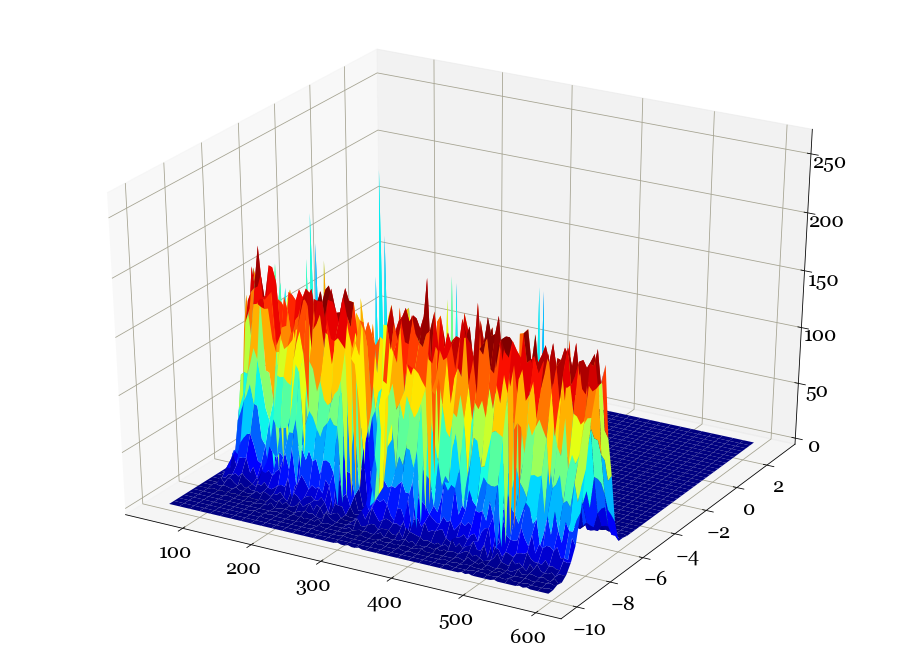

In [16]:
fig = plt.figure()
X, Y = np.meshgrid(redff, bin_centers)
Z = np.zeros_like(X)
for ii in range(np.shape(X)[0]):
    for jj in range(np.shape(X)[1]):
        Z[ii, jj] = hist[jj][1][0][ii]
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap = cm.jet)

In [17]:
psd_dist = []
for ii, f in enumerate(redff):
    psd_dist += [[f, scipy.stats.rv_histogram(hist[ii][1])]]

In [78]:
psd_axis = np.logspace(-5, 1, 600)

In [32]:
np.log(bin_centers)

array([-9.9891551 , -9.7247709 , -9.4603867 , -9.19600249, -8.93161829,
       -8.66723409, -8.40284989, -8.13846568, -7.87408148, -7.60969728,
       -7.34531308, -7.08092887, -6.81654467, -6.55216047, -6.28777627,
       -6.02339206, -5.75900786, -5.49462366, -5.23023946, -4.96585525,
       -4.70147105, -4.43708685, -4.17270265, -3.90831844, -3.64393424,
       -3.37955004, -3.11516584, -2.85078163, -2.58639743, -2.32201323,
       -2.05762903, -1.79324482, -1.52886062, -1.26447642, -1.00009222,
       -0.73570801, -0.47132381, -0.20693961,  0.05744459,  0.3218288 ,
        0.586213  ,  0.8505972 ,  1.1149814 ,  1.37936561,  1.64374981,
        1.90813401,  2.17251821,  2.43690242,  2.70128662,  2.96567082])

In [35]:
hist[0][1][0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   7,  12,  14,  21,  40,  49,  74,  93, 104, 113, 114,  96,
        89,  56,  33,  15,  13,   2,   1,   1,   1,   1,   2,   1,   2,
         2,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2])

In [61]:
from scipy.optimize import curve_fit
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



from scipy.interpolate import interp1d
interpHist = interp1d(bin_centers, hist[30][1][0], kind='cubic')

In [81]:
popt[1]

-6.484015695914997

In [59]:
BNdata = np.loadtxt('/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200528_SuperBNMeasurementSR/Data/BeatnoteSpectrum_20200529_033233.txt')

In [79]:
selInd = 31
popt,pcov = curve_fit(gaus, bin_centers, hist[selInd][1][0], p0=[0.45,-4,2])
print(popt)
ind = np.argmin(np.abs(BNdata[:, 0] - hist[selInd][0]))
print(BNdata[ind, 0], hist[selInd][0])
print(np.log(BNdata[ind, 1]**2), 0.25*(np.log(BNdata[ind, 3]**2) - np.log(BNdata[ind, 2]**2)))
print('15.865% scores:')
print('Data: ', np.log(BNdata[ind, 3]))
print('Calc:', np.log(np.percentile(gaus(np.log(psd_axis), *popt), 84.135)))

[169.01324241  -6.4840157    0.58864572]
210.06722151088348 210.0
-6.730721882796103 0.5879461640802133
15.865% scores:
Data:  -2.8735883887330362
Calc: 3.3640742783627573


In [80]:
(1 - 0.682689492137086)/2

0.15865525393145702

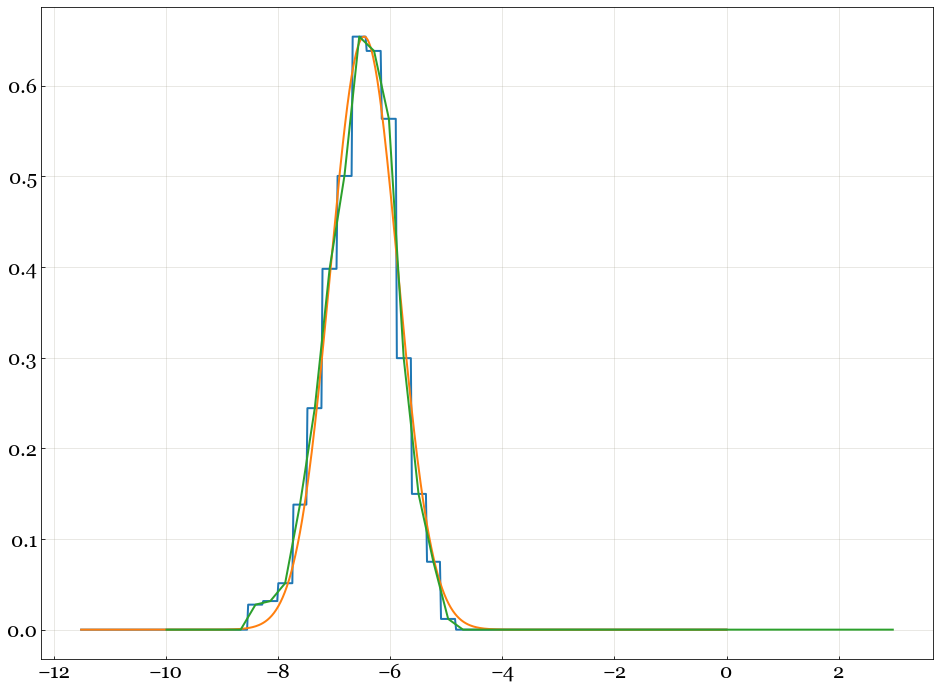

In [57]:
fig = plt.figure()
ax = fig.gca()
ax.plot(np.log(psd_axis), psd_dist[30][1].pdf(np.log(psd_axis)))
norm = np.max(psd_dist[30][1].pdf(np.log(psd_axis)))/np.max(gaus(np.log(psd_axis), *popt))
ax.plot(np.log(psd_axis), norm*gaus(np.log(psd_axis), *popt))
norm2 = np.max(psd_dist[30][1].pdf(np.log(psd_axis)))/np.max(interpHist(bin_centers))
ax.plot(bin_centers, norm2*interpHist(bin_centers))

In [58]:
hist[30]

[205.0,
 (array([  0,   0,   0,   0,   0,   0,   7,   8,  13,  35,  62, 101, 127,
         166, 162, 143,  76,  38,  19,   3,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
  array([-10.1213472 ,  -9.856963  ,  -9.5925788 ,  -9.3281946 ,
          -9.06381039,  -8.79942619,  -8.53504199,  -8.27065779,
          -8.00627358,  -7.74188938,  -7.47750518,  -7.21312098,
          -6.94873677,  -6.68435257,  -6.41996837,  -6.15558417,
          -5.89119996,  -5.62681576,  -5.36243156,  -5.09804736,
          -4.83366315,  -4.56927895,  -4.30489475,  -4.04051054,
          -3.77612634,  -3.51174214,  -3.24735794,  -2.98297373,
          -2.71858953,  -2.45420533,  -2.18982113,  -1.92543692,
          -1.66105272,  -1.39666852,  -1.13228432,  -0.86790011,
          -0.60351591,  -0.33913171,  -0.07474751,   0.1896367 ,
           0.4540209 ,   0.7184051 ,   0.9827893 ,   1

In [113]:
data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5, random_state=123)
hist = np.histogram(data, bins=100)
hist_dist = scipy.stats.rv_histogram(hist)
hist_dist.pdf(1.0)

0.20538577847618705

In [114]:
hist_dist